# Clean Notebook for now

## Imports and data retrieval

### Imports

In [1]:
!pip install pydot


In [2]:
!apt update
!apt install graphviz libgraphviz-dev
!pip install pygraphviz

'apt' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#standard imports, used throughout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from time import time


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

plt.set_cmap('cividis')

#specific Neural Network imports

import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


#imports for scikit learn, for general ML techniques

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from scipy.stats import norm
from scipy.integrate import simpson

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from sewar import ssim
from sewar import rmse

<Figure size 640x480 with 0 Axes>

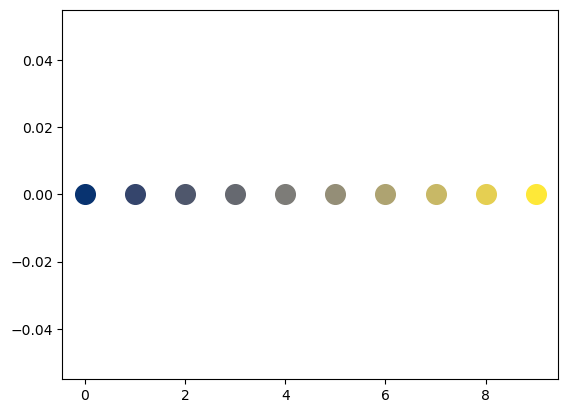

In [4]:
#Creating some colors for use throughout the notebook
cmap = matplotlib.cm.get_cmap('cividis')
colors = [cmap(i) for i in np.arange(0.1, 1.1, 0.1)]
for i, col in enumerate(colors):
  plt.scatter(i, 0, color=colors[i], s=200)

### Data

In [5]:
data = pd.read_csv('sims_custom\dens_data_subtr.csv', sep=',', header=0)
#if you havent preprocessed, add 'index_col=0'

In [6]:
def getData_profile(filename, outputs=[0], features_start=3):
    #read out the data from a csv file and remove n_period column

    data = pd.read_csv(filename, sep=',', header=0)

    if len(outputs)>1:
        y_df = data.iloc[:, outputs[0]:outputs[-1]+1]
    else:
        y_df = data.iloc[:, outputs[0]]
        
    X_df = data.iloc[:, features_start::]
        
    return y_df, X_df

In [7]:
y_df, X_df = getData_profile('sims_custom\dens_data_subtr.csv', outputs=[0, 1, 2])

#now split the first and last measurement distance into two different dataframes
X1_df, X2_df = X_df.iloc[:, :1023], X_df.iloc[:, 1023:]

In [8]:
def add_noise(img, var):
    '''Add random noise to an image'''

    noise = np.random.normal(0, var, img.shape)
    img_noised= noise + img
    return img_noised

## PCA preparation and first model

### Prep and analysis

In [9]:
def preProcessing_PCA(y_df, X_df, comps=5, absorb=True, test_size=0.2, random_state=0, noise=True, var_noise=0.01):
    #Do all the preprocessing steps for training and validation:
    #Remove absorber points
    #Properly expand dimensions
    #Split and renormalize to train max
    #add gaussian noise

    X = np.expand_dims(np.array(X_df), -1) #needed for the convolutional structure
    y = np.array(y_df)


    sss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(X, y[:, 0]))

    x_train, y_train = X[train_idx], y[train_idx]
    x_test, y_test = X[test_idx], y[test_idx]
    
    highest_peak = np.amax(abs(x_train))
    print(highest_peak)
    print(np.amin(x_train))
    x_train /= highest_peak
    x_test  /= highest_peak
    new_max = np.amax(abs(x_train))
    print(new_max)
    #get all the data to be normalized in a sense, to have the largest absolute value of 1
    #then the standard deviation of the noise you add is 1% of this max, quite substantial!
    
    if noise:
        for i, sample in enumerate(x_train):
            x_train[i] = add_noise(sample, var_noise*new_max)
        for i, sample in enumerate(x_test):
            x_test[i] = add_noise(sample, var_noise*new_max)

    pca = PCA(n_components=comps)
    pca.fit(x_train[:, :-1, 0])

    x_pca_train = pca.transform(x_train[:, :-1, 0])
    x_pca_test = pca.transform(x_test[:, :-1, 0])

    return x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca

In [10]:
n_PCA_comps = 20

x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca_model = preProcessing_PCA(y_df, X1_df, comps=n_PCA_comps, absorb=False, noise=True, var_noise=0.01)


503.0
-503.0
1.0


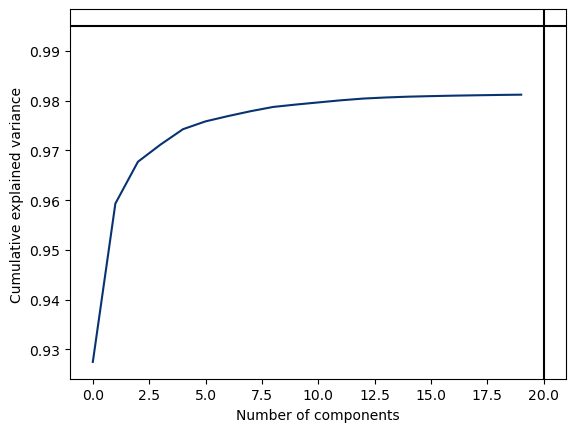

In [11]:
plt.plot(np.cumsum(pca_model.explained_variance_ratio_), c=colors[0])
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(0.995, c='black')
plt.axvline(20, c='black')

So 99.5% of the variance is explained by the first 100 components, which is interesting as it might allow us to make much simpler models in the future.

(0.0, 0.8683533168748028)

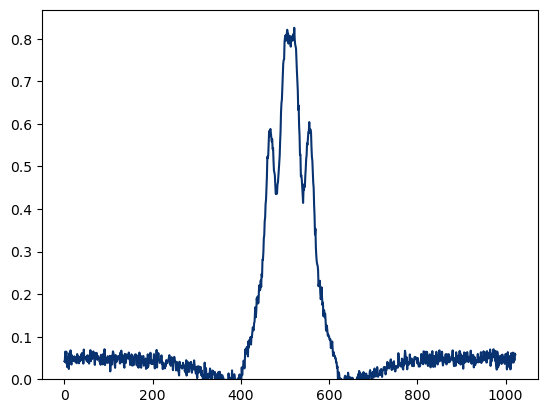

In [12]:
plt.plot(-x_train[800, :, 0]+0.05, c=colors[0])
plt.ylim(0)

#plt.plot(pca_model.inverse_transform(x_pca_train[800]), c=colors[6])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'PCA comp 2')

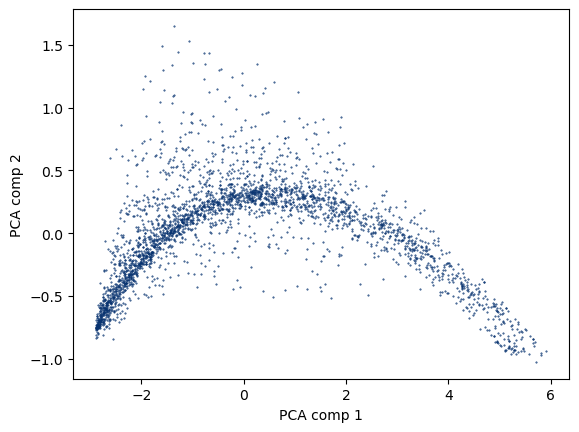

In [13]:
plt.scatter(x_pca_train[:, 0], x_pca_train[:, 1], s=0.2, c=colors[0])
plt.xlabel('PCA comp 1')
plt.ylabel('PCA comp 2')

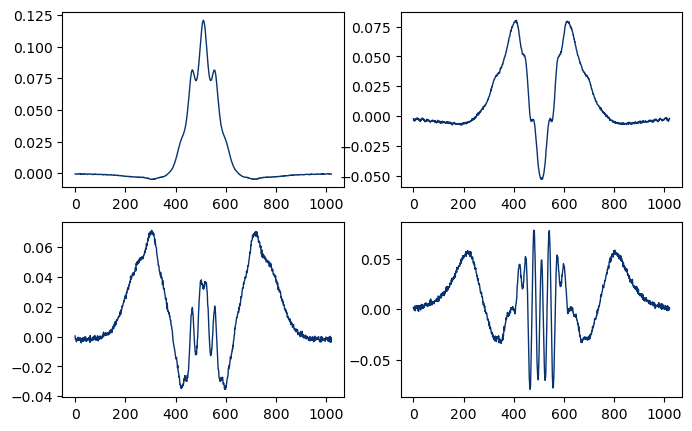

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))

ax[0, 0].plot(pca_model.components_[0], linewidth=1, label='1', c=colors[0])
ax[0, 1].plot(pca_model.components_[1], linewidth=1, label='2', c=colors[0])
ax[1, 0].plot(pca_model.components_[2], linewidth=1, label='3', c=colors[0])
ax[1, 1].plot(pca_model.components_[3], linewidth=1, label='4', c=colors[0])

### Parametric neural network, for only 1 output

In [15]:
pca_model_NN = tf.keras.Sequential([
  layers.Dense(128, activation='relu', input_dim=n_PCA_comps, name='first'),
  layers.Dense(32, activation='relu', name='second'),
  layers.Dense(1, activation='sigmoid', name='output')
])

pca_model_NN.compile(loss = tf.keras.losses.MeanSquaredError(),
                      optimizer = tf.keras.optimizers.Adam())

#the callbacks that are used to implement early stopping and retrieve the best performing model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc_pca = ModelCheckpoint('NN_PCA.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

In [16]:
history_pca_NN = pca_model_NN.fit(x_pca_train, y_train[:, 0], validation_data=(x_pca_test, y_test[:, 0]), epochs=200, verbose=0, callbacks=[es, mc_pca])

pca_saved_model_NN = load_model('NN_PCA.h5')

Epoch 119: early stopping


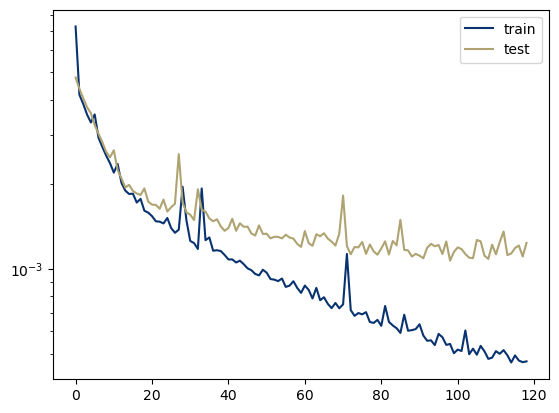

In [17]:
plt.plot(history_pca_NN.history['loss'], label='train', c=colors[0])
plt.plot(history_pca_NN.history['val_loss'], label='test', c=colors[6])
plt.yscale('log')
plt.legend()
plt.show()

loss_nn_pca = history_pca_NN.history['loss'][-1]
#this loss is only on your training data, and is probably overfitting already! Introducing an earlystopping can prevent it by checking on separate files!


23/23 [==============================] - 0s 1ms/step


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 1.0936432500000002)

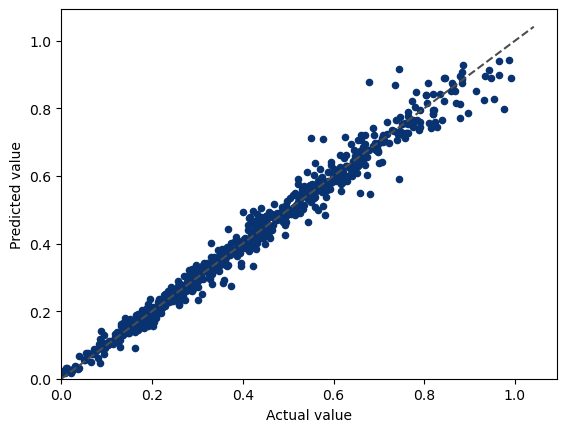

In [18]:
fig, ax = plt.subplots()

ax.scatter(y_test[:, 0], pca_saved_model_NN.predict(x_pca_test), s=20, c=colors[0])
xval = np.linspace(0, ax.get_xlim()[1], 100)
yval = np.linspace(0, ax.get_ylim()[1], 100)

ax.plot(xval, xval, ls="--", c=".3")
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
ax.set_xlim(0)
ax.set_ylim(0)

23/23 [==============================] - 0s 727us/step


Text(0.5, 0, 'Absolute error on prediction')

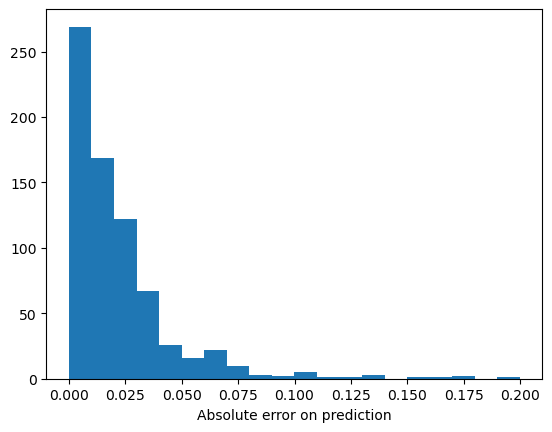

In [19]:
errors = y_test[:, 0] - pca_saved_model_NN.predict(x_pca_test)[:, 0]

plt.hist(abs(errors), bins=20)
plt.xlabel('Absolute error on prediction')

### GBR Benchmark

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [56]:
gb_pca = GradientBoostingRegressor(n_estimators=1000)
gb_pca.fit(x_pca_train, y_train[:, 0])

GradientBoostingRegressor(n_estimators=1000)

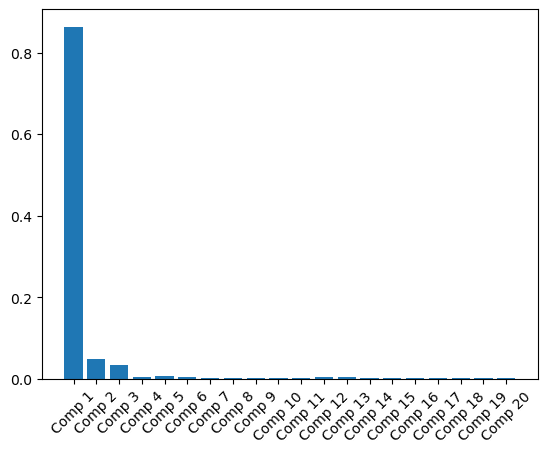

In [57]:
plt.bar(range(x_pca_train.shape[1]), gb_pca.feature_importances_)
plt.xticks(range(x_pca_train.shape[1]), ['Comp {}'.format(i) for i in range(1, 21)], rotation=45)
np.set_printoptions(False)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 1.079337)

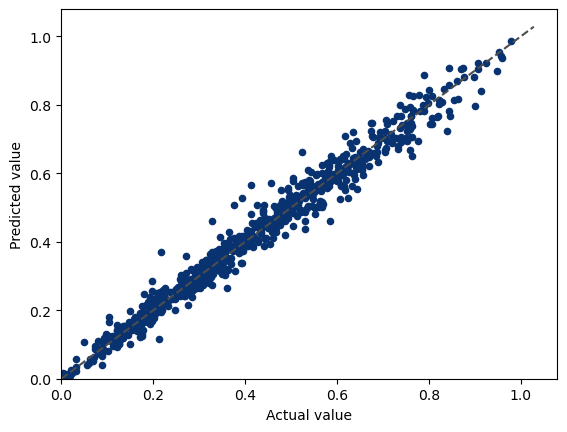

In [58]:
fig, ax = plt.subplots()

ax.scatter(y_test[:, 0], gb_pca.predict(x_pca_test), s=20, c=colors[0])

xval = np.linspace(0, ax.get_xlim()[1], 100)
yval = np.linspace(0, ax.get_ylim()[1], 100)

ax.plot(xval, xval, ls="--", c=".3")
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
ax.set_xlim(0)
ax.set_ylim(0)

## Parametric model

### Training and setup

In [20]:
y_df, X_df = getData_profile('sims_custom\dens_data_subtr.csv', outputs=[0, 1, 2])

#now split the first and last measurement distance into two different dataframes
X1_df, X2_df = X_df.iloc[:, :1023], X_df.iloc[:, 1023:]

x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca_model = preProcessing_PCA(y_df, X1_df, comps=n_PCA_comps, absorb=False, noise=True)

profile_input = keras.Input(shape=x_train[0].shape, name="profile")  # Variable-length sequence of ints



x = layers.AveragePooling1D(pool_size=3, strides=1, padding='same', name='pool1')(profile_input)
x = layers.Conv1D(8, kernel_size=3, padding='same', name='conv1')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool2')(x)
x = layers.Conv1D(16, kernel_size=5, padding='same', name='conv2')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool3')(x)
x = layers.Conv1D(16, kernel_size=7, padding='same', name='conv3')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool4')(x)
profile_output = layers.Flatten(name='flatten')(x)


drop = layers.Dropout(0.1, name='drop1')(profile_output)
#pred = layers.Dense(512, activation='relu', name='dens1')(drop)
#drop = layers.Dropout(0.1, name='drop2')(pred)
pred = layers.Dense(256, activation='relu', name='dens2')(drop)
drop = layers.Dropout(0.1, name='drop3')(pred)
pred1 = layers.Dense(32, activation='relu', name='dens3')(drop)
pred2 = layers.Dense(32, activation='relu', name='dens3a')(drop)
pred3 = layers.Dense(32, activation='relu', name='dens3b')(drop)

ne_peak_pred = layers.Dense(1, activation='sigmoid', name='ne_peak')(pred1)
exponent_pred = layers.Dense(1, activation='relu', name='exponent')(pred2)
stdev_pred = layers.Dense(1, activation='relu', name='stdev')(pred3)

custom_parametric = keras.Model(
    inputs=[profile_input],
    outputs=[ne_peak_pred, exponent_pred, stdev_pred]
)

custom_parametric.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()],
           loss_weights=[1.0, 1.e-2, 1.e-2])
#custom_parametric.summary()
#plot_model(model, 'model.png', show_shapes=False)

503.0
-503.0
1.0


In [21]:
es = EarlyStopping(monitor='val_ne_peak_loss', mode='min', verbose=2, patience=10)
mc = ModelCheckpoint('custom_parametric.h5', monitor='val_ne_peak_loss', mode='min', verbose=0, save_best_only=True)

start = time()
history_custom = custom_parametric.fit({'profile': x_train},
                    {'ne_peak' : y_train[:, 0], 'exponent' : y_train[:, 1], 'stdev' : y_train[:, 2]},
                    validation_data=({'profile': x_test}, {'ne_peak' : y_test[:, 0], 'exponent' : y_test[:, 1],
                     'stdev' : y_test[:, 2]}),
                    epochs=100, verbose=2, callbacks=[es, mc])


print(str(time()-start) + 'seconds')

Epoch 1/100
91/91 - 6s - loss: 0.0537 - ne_peak_loss: 0.0115 - exponent_loss: 0.6576 - stdev_loss: 3.5609 - val_loss: 0.0224 - val_ne_peak_loss: 0.0053 - val_exponent_loss: 0.4216 - val_stdev_loss: 1.2866 - 6s/epoch - 64ms/step
Epoch 2/100
91/91 - 4s - loss: 0.0216 - ne_peak_loss: 0.0062 - exponent_loss: 0.3903 - stdev_loss: 1.1558 - val_loss: 0.0220 - val_ne_peak_loss: 0.0071 - val_exponent_loss: 0.3666 - val_stdev_loss: 1.1277 - 4s/epoch - 44ms/step
Epoch 3/100
91/91 - 4s - loss: 0.0200 - ne_peak_loss: 0.0057 - exponent_loss: 0.3782 - stdev_loss: 1.0520 - val_loss: 0.0186 - val_ne_peak_loss: 0.0052 - val_exponent_loss: 0.3222 - val_stdev_loss: 1.0237 - 4s/epoch - 45ms/step
Epoch 4/100
91/91 - 4s - loss: 0.0191 - ne_peak_loss: 0.0053 - exponent_loss: 0.3661 - stdev_loss: 1.0175 - val_loss: 0.0267 - val_ne_peak_loss: 0.0053 - val_exponent_loss: 0.4083 - val_stdev_loss: 1.7318 - 4s/epoch - 41ms/step
Epoch 5/100
91/91 - 5s - loss: 0.0195 - ne_peak_loss: 0.0061 - exponent_loss: 0.3511 - s

In [22]:
saved_parametric = load_model('custom_parametric.h5')

In [23]:
#custom_loss = history_custom.history['val_ne_peak_loss'][-1]
[ne_pred_par, exp_pred_par, stdev_pred_par] = saved_parametric.predict({'profile': x_test})


23/23 [==============================] - 0s 12ms/step


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 7.58835)

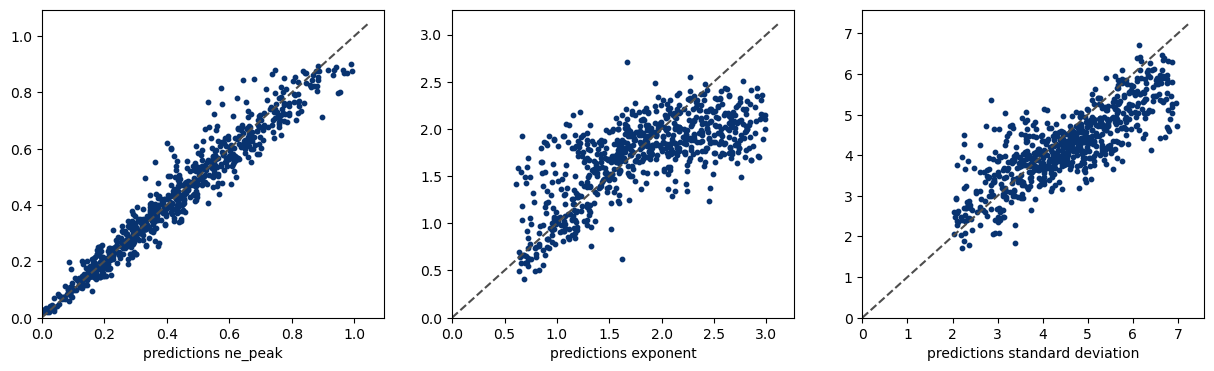

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(y_test[:, 0], ne_pred_par, s=10, c=colors[0])
ax[0].set_xlabel('predictions ne_peak')
xval_ne = np.linspace(0, ax[0].get_xlim()[1], 100)
yval_ne = np.linspace(0, ax[0].get_ylim()[1], 100)

ax[0].plot(xval_ne, xval_ne, ls="--", c=".3")
ax[0].set_xlim(0)
ax[0].set_ylim(0)

ax[1].scatter(y_test[:, 1], exp_pred_par, s=10, c=colors[0])
ax[1].set_xlabel('predictions exponent')
xval_exp = np.linspace(0, ax[1].get_xlim()[1], 100)
yval_exp = np.linspace(0, ax[1].get_ylim()[1], 100)

ax[1].plot(xval_exp, xval_exp, ls="--", c=".3")
ax[1].set_xlim(0)
ax[1].set_ylim(0)

ax[2].scatter(y_test[:, 2], stdev_pred_par, s=10, c=colors[0])
ax[2].set_xlabel('predictions standard deviation')
xval_stdev = np.linspace(0, ax[2].get_xlim()[1], 100)
yval_stdev = np.linspace(0, ax[2].get_ylim()[1], 100)

ax[2].plot(xval_stdev, xval_stdev, ls="--", c=".3")
ax[2].set_xlim(0)
ax[2].set_ylim(0)

### Comparing profiles

Why the following numbers?

We are using n_period 64, so 64 cells in the simulation per wavelength. The total field is 640*4 and with the absorbers subtracted, we're left with a field of 2048 by 2048. Now this is quite a bit too many values, and we just want to know the plasma profile inside of the quartz tube. The radius_in and _out given below are the values in number of gridpoints. The largest inscribed square in this circle has sides of length 848, so we want the window of interest to be about this, hence the 605 to 1445. This is 420 points away from the centre on each side. Now we want this 840x840 field reduced to 20x20, so we skip 42 values, or take the average at least.

In [25]:
def reduce_dimension(arr, new_shape):

    #instead of just taking the hypergaussian at every 42nd place, it is perhaps better
    #to take the average over its values.
    
    row_size = arr.shape[0] // new_shape[0]
    col_size = arr.shape[1] // new_shape[1]
    new_arr = np.zeros(new_shape)
    for i in range(new_shape[0]):
        for j in range(new_shape[1]):
            start_row = i * row_size
            end_row = start_row + row_size
            start_col = j * col_size
            end_col = start_col + col_size
            new_arr[i][j] = arr[start_row:end_row, start_col:end_col].mean()
    return new_arr

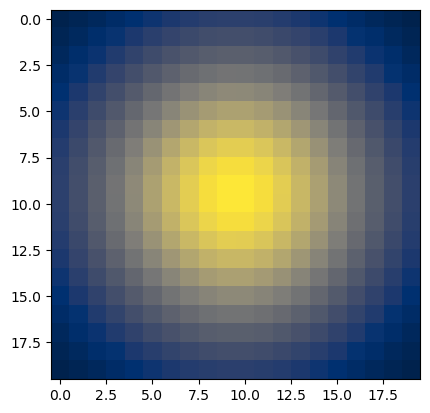

In [26]:
x = np.arange(0, 2048)
y = np.arange(0, 2048)

x = np.arange(605, 1445)
y = np.arange(605, 1445)

#x = np.arange(550, 1050, 26)
#y = np.arange(550, 1050, 26)

xv, yv = np.meshgrid(x, y, indexing='ij')


def gaussian(xv, yv, peak, pos_x, pos_y, stdev_x, stdev_y):
    return peak * np.exp(-((xv-pos_x)/np.sqrt(2)/stdev_x)**2 - ((yv-pos_y)/np.sqrt(2)/stdev_y)**2)

#the stdev is in number of wavelengths
#the divided by two is because this 64 is the n_period, so the amount of cells taken by a wavelength in the simulation
#but the output is only every second cell, so in the images below (which had originally 2048 values, now 1024) it needs to be halved

def hypergaussian(peak, expon, stdev_x=1, xv = xv, yv = yv, pos_x=1024, pos_y=1024):
    r2 = ((xv-pos_x)/np.sqrt(2)/(64*stdev_x))**2 + ((yv-pos_y)/np.sqrt(2)/(64*stdev_x))**2
    return peak * np.exp(-r2**expon)

def quartz(ne_peak = 1, xv = xv, yv = yv, radius_in=599.55, radius_out=666.18, pos_x=1024, pos_y=1024):

    bool1 = radius_in < np.sqrt((xv -pos_x)**2 + (yv -pos_y)**2)
    bool2 =  np.sqrt((xv -pos_x)**2 + (yv -pos_y)**2) < radius_out

    return np.where(bool1 & bool2, ne_peak/4, 0)


z2 = hypergaussian(0.8, 1, 3.5)


z2_red = reduce_dimension(z2, [20, 20])
quartz_pos = quartz()
plt.imshow(z2_red)

In [27]:
def compareProfiles():
    index = 0
    while index != -1:

        clear_output()
        plt.set_cmap('cividis')
        prediction = saved_parametric.predict({'profile': np.expand_dims(x_test[index], 0)})
        truth = y_test[index]

        x = np.arange(605, 1445)
        y = np.arange(605, 1445)

        xv, yv = np.meshgrid(x, y, indexing='ij')

        z_true = reduce_dimension(hypergaussian(truth[0], truth[1], truth[2], xv=xv, yv=yv), [40, 40])
        z_pred = reduce_dimension(hypergaussian(prediction[0], prediction[1], prediction[2], xv=xv, yv=yv), [40, 40])

        fig, ax = plt.subplots(1, 3, figsize=(11, 3))

        im_true = ax[0].plot(np.diag(z_true), label='Ground truth', linestyle='--', c=colors[0])
        ax[0].set_xlabel('Position on diagonal', fontsize=14)
        ax[0].set_ylabel(r'$n_e/n_{crit}$', fontsize=16)

        ax[0].plot(np.diag(z_pred), label='Prediction', c='orange')
        ax[0].set_xlim((0, 39))
        ax[0].set_ylim((0, 1))
        ax[0].legend(loc='upper left', fontsize=9)
        ax[0].tick_params(axis='both', which='major', labelsize=12)
        #//set the ticksize to 12 for the above figure ax[0]
        #plt.colorbar(im_true)

        max_value = np.max([z_true.max(), z_pred.max()])
        min_value = np.min([z_true.min(), z_pred.min()])

        #change to max and min_value to see more clear differences. But this maybe hits the point home
        #that we have really good agreement.
        true = ax[1].imshow(z_true, vmax=0.8, vmin=0)
        ax[1].set_title('True profile', fontsize=14)
        ax[1].tick_params(axis='both', which='major', labelsize=12)

        ax[2].imshow(z_pred, vmax=0.8, vmin=0)
        ax[2].set_title('Predicted profile', fontsize=14)
        ax[2].tick_params(axis='both', which='major', labelsize=12)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.83, 0.13, 0.02, 0.725])
        cbar = fig.colorbar(true, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=12)

        plt.show()


        index = int(input(f"Select new index, -1 to stop: "))

    return


1/1 [==============================] - 0s 18ms/step


<Figure size 640x480 with 0 Axes>

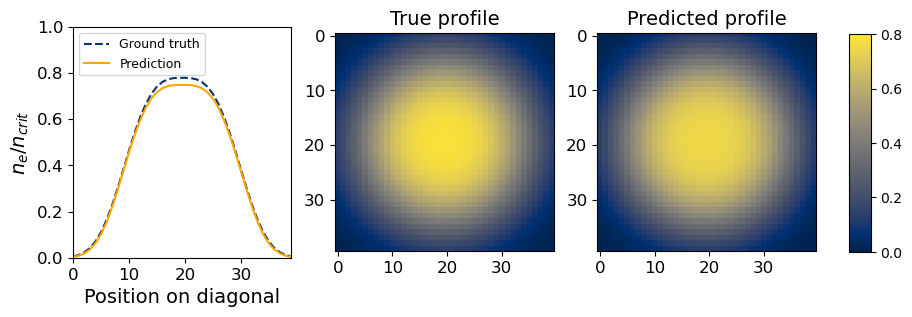

In [25]:
compareProfiles()

## Resolved model

### Get data

In [28]:
x = np.arange(605, 1445)
y = np.arange(605, 1445)

xv, yv = np.meshgrid(x, y, indexing='ij')

In [29]:
"""Making new training and testing data, by now having the output as the resolved images"""

y_train_new = np.array([reduce_dimension(hypergaussian(train_sample[0], train_sample[1], train_sample[2], xv=xv, yv=yv), [40, 40])
 for i, train_sample in enumerate(y_train)])
y_test_new = np.array([reduce_dimension(hypergaussian(test_sample[0], test_sample[1], test_sample[2], xv=xv, yv=yv), [40, 40])
 for i, test_sample in enumerate(y_test)])

#y_train_new = np.array([new_func(train_sample[0], train_sample[1]) for i, train_sample in enumerate(y_train)])
#y_test_new = np.array([new_func(test_sample[0], test_sample[1]) for i, test_sample in enumerate(y_test)])
#.reshape(400,)
y_train_new.shape

(2881, 40, 40)

In [30]:
y_train_new[0].shape

(40, 40)

In [31]:
def create_resolved_model(loss_fn, num_conv_pool=3, num_dense_layers=2, dense_nodes=[500, 500], dropout_rate=0.1, optimizer='Adam'):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.AveragePooling1D(pool_size=5, strides=4, padding='same', name='pool1'))

    for i in range(num_conv_pool):

        kernelsize = int(np.max([3, (2**(4-i)-1)]))
        model.add(tf.keras.layers.Conv1D(np.min([8*(2**i), 32]), kernel_size=kernelsize,padding='same', name=f'conv{i+1}'))
        #next two lines are still to be tried out
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='same', name=f'pool{i+2}'))

    model.add(tf.keras.layers.Flatten(name='flatten'))


    for i in range(num_dense_layers):
        model.add(tf.keras.layers.Dropout(dropout_rate, name=f'drop{i+1}'))
        model.add(tf.keras.layers.Dense(dense_nodes[i], activation='relu', name=f'dens{i+1}'))

    model.add(tf.keras.layers.Reshape((5, 5, dense_nodes[-1]//25)))

    model.add(tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    #this is when you want 40x40
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))


    optimizer = getattr(tf.keras.optimizers, optimizer)()
    model.compile(optimizer=optimizer, loss=loss_fn)

    return model


### Loss functions

In [32]:
import keras.backend as K

def nrmse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))
    rmse = K.sqrt(mse)
    min_val = K.min(y_true)
    max_val = K.max(y_true)
    return rmse / (max_val - min_val)



In [33]:
from skimage.metrics import structural_similarity as ssim
#non-differentiable, don't use for training!


def ssim_loss(y_true, y_pred):
    # Define the custom loss function here
    ssim_val = 1 - ssim(y_true, y_pred, multichannel=True)
    return ssim_val



In [34]:
#non-differentiable, don't use for training!

def psnr(y_true, y_pred):
    max_pixel = K.max(y_true)
    return 20 * K.log(max_pixel / K.sqrt(K.mean(K.square(y_true - y_pred)))) / K.log(10.0)

In [ ]:
#non-differentiable, don't use for training!

def cross_correlation(y_true, y_pred):
    cross_corr = correlate2d(y_true, y_pred, mode='full')
    return -cross_corr.max()

In [35]:
def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

In [36]:
def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))
    return 100. * K.mean(diff)

In [37]:
def cosine_similarity(y_true, y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    cosine_similarity = 1 - K.sum(y_true * y_pred, axis=-1)
    return -K.mean(cosine_similarity)


### Initializing and training

In [38]:
res_model = create_resolved_model(loss_fn=tf.keras.losses.MeanSquaredError(), num_conv_pool=4, dense_nodes=[750, 750])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc_full = ModelCheckpoint('custom_resolved.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_res = res_model.fit(x_train, y_train_new, validation_data=(x_test, y_test_new), batch_size=50, epochs=200, verbose=1, callbacks=[es, mc_full])


Epoch 1/200
58/58 [==============================] - 8s 86ms/step - loss: 0.0916 - val_loss: 0.0909
Epoch 2/200
58/58 [==============================] - 7s 120ms/step - loss: 0.0565 - val_loss: 0.0772
Epoch 3/200
58/58 [==============================] - 4s 70ms/step - loss: 0.0233 - val_loss: 0.0509
Epoch 4/200
58/58 [==============================] - 4s 71ms/step - loss: 0.0122 - val_loss: 0.0418
Epoch 5/200
58/58 [==============================] - 4s 71ms/step - loss: 0.0107 - val_loss: 0.0298
Epoch 6/200
58/58 [==============================] - 4s 70ms/step - loss: 0.0099 - val_loss: 0.0381
Epoch 7/200
58/58 [==============================] - 4s 76ms/step - loss: 0.0092 - val_loss: 0.0201
Epoch 8/200
58/58 [==============================] - 4s 78ms/step - loss: 0.0089 - val_loss: 0.0183
Epoch 9/200
58/58 [==============================] - 5s 80ms/step - loss: 0.0084 - val_loss: 0.0162
Epoch 10/200
58/58 [==============================] - 5s 79ms/step - loss: 0.0078 - val_loss: 0.019

In [39]:
saved_resolved = load_model('custom_resolved.h5')

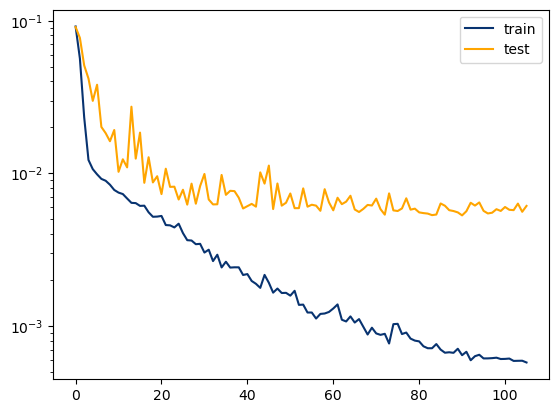

In [40]:
plt.plot(history_res.history['loss'], label='train', c=colors[0])
plt.plot(history_res.history['val_loss'], label='test', c='orange')
plt.yscale('log')
plt.legend()
plt.show()

loss_res = history_res.history['loss'][-1]

### Comaring profiles

In [41]:
def ResCompareProfiles(model, x, y, threeD=True):
    index = 0
    while index != -1:

        clear_output()
        plt.set_cmap('cividis')

        prediction = model.predict(np.expand_dims(x[index], 0)).reshape((40, 40))
        print(prediction.shape)
        truth = y[index].reshape((40, 40))


        fig, ax = plt.subplots(1, 3, figsize=(11, 3))


        im_true = ax[0].plot(np.diag(truth), label='Ground truth', linestyle='--', c=colors[0])
        ax[0].set_xlabel('Position on diagonal', fontsize=14)
        ax[0].set_ylabel(r'$n_e/n_{crit}$', fontsize=16)

        ax[0].plot(np.diag(prediction), label='Prediction', c='orange')
        ax[0].set_xlim((0, 39))
        ax[0].set_ylim((0, 1))
        ax[0].legend(loc='upper left', fontsize=9)
        ax[0].tick_params(axis='both', which='major', labelsize=12)
        
        max_value = np.max([truth, prediction])
        min_value = np.min([truth, prediction])

        norm_true = (truth /max_value * 255).astype(int)
        norm_pred = (prediction /max_value * 255).astype(int)
        
        #true = ax[1].imshow(norm_true, vmax=255, vmin=(min_value*255).astype(int))
        true = ax[1].imshow(truth, vmax=0.8, vmin=0)
        ax[1].set_title('True profile', fontsize=14)
        ax[1].tick_params(axis='both', which='major', labelsize=12)
        #ax[2].imshow(norm_pred, vmax=255, vmin=(min_value*255).astype(int))
        ax[2].imshow(prediction, vmax=0.8, vmin=0)
        ax[2].set_title('Predicted profile', fontsize=14)
        ax[2].tick_params(axis='both', which='major', labelsize=12)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.83, 0.13, 0.02, 0.725]) # [left, bottom, width, height] 
        #//make the cbar_ax above be abit closer to the ax[2] figure
        cbar = fig.colorbar(true, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=12)

        print(cosine_similarity(norm_true, norm_pred))


        plt.show()

        if threeD: 
            fig = plt.figure(figsize=(8, 4))

            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')
            X, Y = np.meshgrid(np.arange(truth.shape[1]), np.arange(truth.shape[0]))
            ax1.plot_surface(X, Y, truth, vmax=0.8, vmin=0, cmap='cividis')
            ax1.set_zlim(0, 0.8)
            ax1.set_title('True profile')
            ax2.plot_surface(X, Y, prediction, vmax=0.8, vmin=0, cmap='cividis')
            ax2.set_zlim(0, 0.8)
            ax2.set_title('Predicted profile')

            plt.show()

        index = int(input(f"Select new index, -1 to stop: "))

    return


1/1 [==============================] - 0s 17ms/step
(40, 40)
tf.Tensor(-0.0539146, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

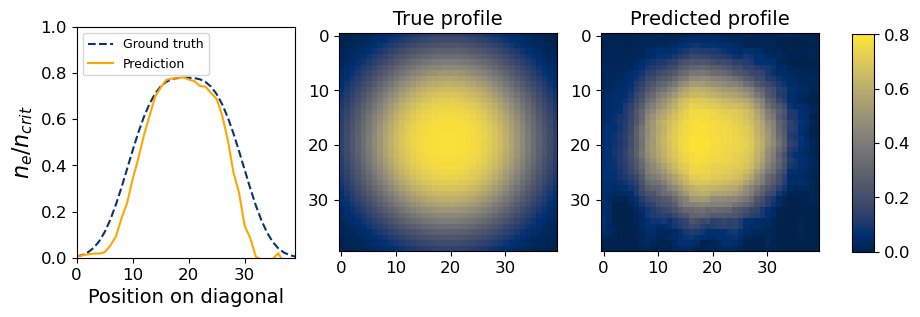

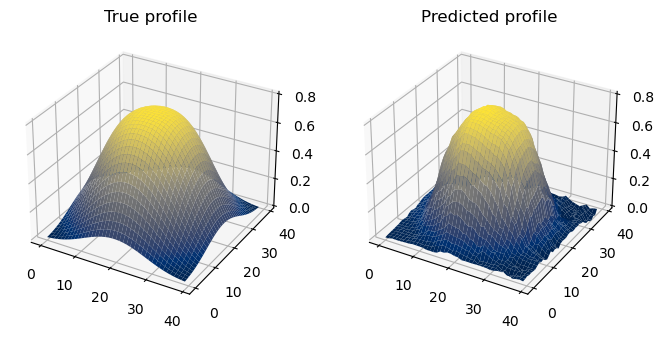

In [92]:
ResCompareProfiles(saved_resolved, x=x_test, y=y_test_new)

## Deepnis-like improvement

In [93]:
x_train.shape

(2886, 1023, 1)

In [94]:
predictions_train = saved_resolved.predict(x_train) #.reshape(-1, 40, 40)

predictions_test = saved_resolved.predict(x_test) #.reshape(-1, 40, 40)

23/23 [==============================] - 0s 5ms/step


In [95]:
predictions_train.shape

(2886, 40, 40, 1)

In [74]:
def superres_model(loss_fn, optimizer='Adam'):

    inputs = keras.Input(shape=(40,40, 1), name="img")
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(16, 3,  activation="relu", padding="same")(x)
    x = layers.Conv2D(1, 3,  activation="relu", padding="same")(x)
    outputs = layers.add([x, inputs])
    """
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    outputs = layers.add([x, block_1_output])
    """
    model = keras.Model(inputs, outputs, name="super_resolution")

    optimizer = getattr(tf.keras.optimizers, optimizer)()
    model.compile(optimizer=optimizer, loss=loss_fn)

    return model


In [109]:
def superres_model(loss_fn, optimizer='Adam'):





    inputs = keras.Input(shape=(40,40, 1), name="img")
    
    #x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation="relu")(inputs)
    #x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation="relu")(inputs)

    x = layers.AveragePooling2D((2, 2), strides=(1, 1), padding="same")(inputs)

    x = layers.Conv2D(1, 5,  activation="relu", padding="same")(x)
    outputs = layers.add([x, inputs])
    """
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    outputs = layers.add([x, block_1_output])
    """
    model = keras.Model(inputs, outputs, name="super_resolution")

    optimizer = getattr(tf.keras.optimizers, optimizer)()
    model.compile(optimizer=optimizer, loss=loss_fn)

    return model


In [110]:
superres = superres_model(loss_fn=tf.keras.losses.MeanSquaredError())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_full = ModelCheckpoint('superres.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_superres = superres.fit(predictions_train, y_train_new, validation_data=(predictions_test, y_test_new), batch_size=50, epochs=10, verbose=1, callbacks=[es, mc_full])


Epoch 1/10
58/58 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 2/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 3/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 4/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 5/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 6/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 6: early stopping


In [1]:
ResCompareProfiles(superres, x=predictions_test, y=y_test_new)

NameError: name 'ResCompareProfiles' is not defined

## Resolved with different losses

In [42]:
res_model_a = create_resolved_model(loss_fn=tf.losses.MeanAbsoluteError())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc_full = ModelCheckpoint('custom_resolved_a.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_res_a = res_model_a.fit(x_train, y_train_new, validation_data=(x_test, y_test_new), batch_size=50, epochs=200, verbose=1, callbacks=[es, mc_full])


Epoch 1/200
58/58 [==============================] - 7s 82ms/step - loss: 0.1870 - val_loss: 0.2030
Epoch 2/200
58/58 [==============================] - 5s 84ms/step - loss: 0.1200 - val_loss: 0.1780
Epoch 3/200
58/58 [==============================] - 5s 83ms/step - loss: 0.0922 - val_loss: 0.1449
Epoch 4/200
58/58 [==============================] - 4s 75ms/step - loss: 0.0827 - val_loss: 0.1399
Epoch 5/200
58/58 [==============================] - 5s 83ms/step - loss: 0.0767 - val_loss: 0.1381
Epoch 6/200
58/58 [==============================] - 5s 79ms/step - loss: 0.0731 - val_loss: 0.1535
Epoch 7/200
58/58 [==============================] - 4s 78ms/step - loss: 0.0703 - val_loss: 0.1246
Epoch 8/200
58/58 [==============================] - 5s 81ms/step - loss: 0.0682 - val_loss: 0.1125
Epoch 9/200
58/58 [==============================] - 5s 79ms/step - loss: 0.0681 - val_loss: 0.1018
Epoch 10/200
58/58 [==============================] - 5s 78ms/step - loss: 0.0632 - val_loss: 0.0877

In [43]:
saved_resolved_a = load_model('custom_resolved_a.h5')

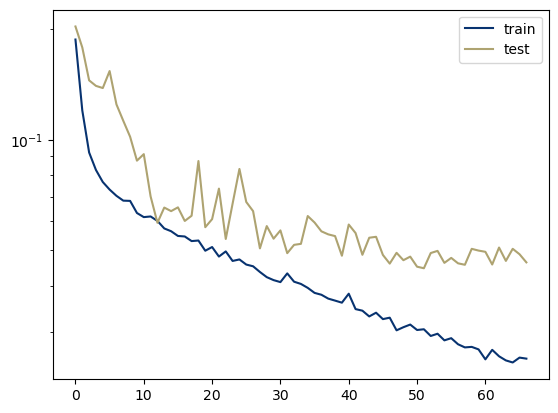

In [44]:
plt.plot(history_res_a.history['loss'], label='train', color=colors[0])
plt.plot(history_res_a.history['val_loss'], label='test', color=colors[6])
plt.yscale('log')
plt.legend()
plt.show()

loss_res_a = history_res_a.history['loss'][-1]

1/1 [==============================] - 0s 18ms/step


tf.Tensor(-0.0009480864, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

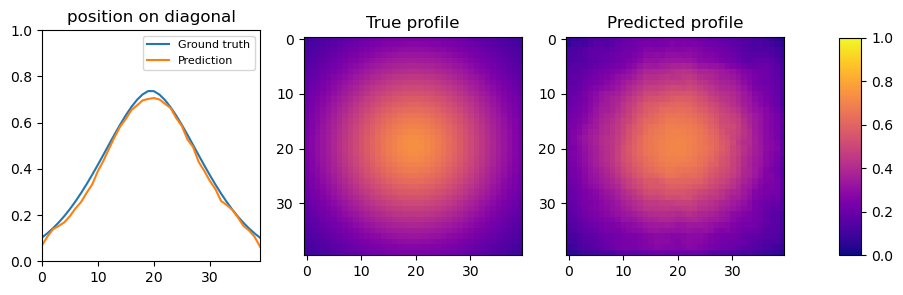

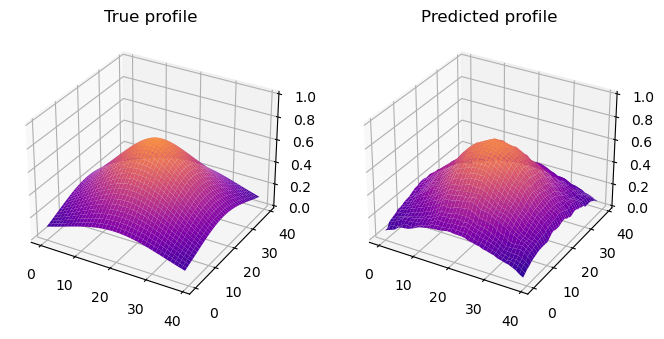

In [84]:
ResCompareProfiles(saved_resolved_a, x=x_test, y=y_test_new)

## 2D input

In [45]:
x_train_2, x_pca_train_2, x_test_2, x_pca_test_2, y_train, y_test, pca_model = preProcessing_PCA(y_df, X_df, comps=n_PCA_comps, absorb=False, noise=True)

503.0
-503.0
1.0


In [46]:
x_train_2.shape

(2881, 2046, 1)

In [47]:
x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0], -1, 2))
x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0], -1, 2))

In [48]:
x_test_2.shape

(721, 1023, 2)

In [49]:
res_model_2d = create_resolved_model(loss_fn=tf.keras.losses.MeanSquaredError(), num_conv_pool=4, dense_nodes=[750, 750])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc_full = ModelCheckpoint('custom_resolved_2d.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_res_2d = res_model_2d.fit(x_train_2, y_train_new, validation_data=(x_test_2, y_test_new), batch_size=50, epochs=200, verbose=1, callbacks=[es, mc_full])


Epoch 1/200
58/58 [==============================] - 7s 81ms/step - loss: 0.0781 - val_loss: 0.0866
Epoch 2/200
58/58 [==============================] - 4s 71ms/step - loss: 0.0426 - val_loss: 0.0718
Epoch 3/200
58/58 [==============================] - 4s 68ms/step - loss: 0.0252 - val_loss: 0.0832
Epoch 4/200
58/58 [==============================] - 4s 69ms/step - loss: 0.0167 - val_loss: 0.0624
Epoch 5/200
58/58 [==============================] - 4s 66ms/step - loss: 0.0123 - val_loss: 0.0833
Epoch 6/200
58/58 [==============================] - 4s 74ms/step - loss: 0.0110 - val_loss: 0.0639
Epoch 7/200
58/58 [==============================] - 4s 68ms/step - loss: 0.0093 - val_loss: 0.0720
Epoch 8/200
58/58 [==============================] - 4s 71ms/step - loss: 0.0092 - val_loss: 0.0510
Epoch 9/200
58/58 [==============================] - 4s 73ms/step - loss: 0.0085 - val_loss: 0.0441
Epoch 10/200
58/58 [==============================] - 4s 72ms/step - loss: 0.0081 - val_loss: 0.0295

In [50]:
saved_resolved_2d = load_model('custom_resolved_2D.h5')

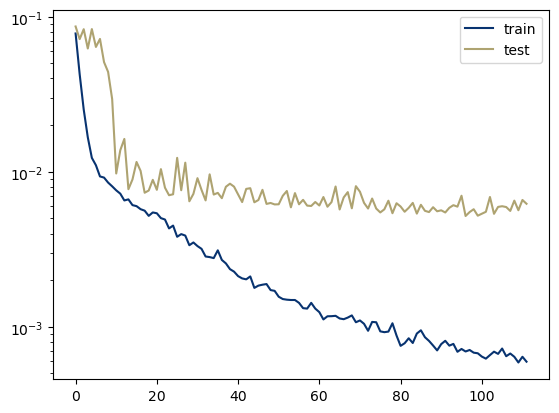

0.006221926771104336


In [51]:
plt.plot(history_res_2d.history['loss'], label='train', color=colors[0])
plt.plot(history_res_2d.history['val_loss'], label='test', color=colors[6])
plt.yscale('log')
plt.legend()
plt.show()

loss_try = history_res_2d.history['val_loss'][-1]
print(loss_try)

In [1]:
ResCompareProfiles(saved_resolved_2d, x=x_test_2, y=y_test_new)

NameError: name 'ResCompareProfiles' is not defined

In [83]:
print(saved_resolved_2d.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pool1 (AveragePooling1D)    (None, 256, 2)            0         
                                                                 
 conv1 (Conv1D)              (None, 256, 8)            248       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 256, 8)            0         
                                                                 
 batch_normalization_19 (Bat  (None, 256, 8)           32        
 chNormalization)                                                
                                                                 
 pool2 (MaxPooling1D)        (None, 128, 8)            0         
                                                                 
 conv2 (Conv1D)              (None, 128, 16)           912       
                                                     

## PCA resolved - considerably worse!

In [52]:
n_PCA_comps = 256

x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca_model = preProcessing_PCA(y_df, X1_df, comps=n_PCA_comps, absorb=False, noise=True, var_noise=0.01)


503.0
-503.0
1.0


In [53]:
x = np.arange(605, 1445)
y = np.arange(605, 1445)

xv, yv = np.meshgrid(x, y, indexing='ij')

In [54]:
def create_resolved_PCA_model(loss_fn, num_dense_layers=2, dense_nodes=[500, 500], dropout_rate=0.1, optimizer='Adam'):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.BatchNormalization())


    for i in range(num_dense_layers):
        model.add(tf.keras.layers.Dropout(dropout_rate, name=f'drop{i+1}'))
        model.add(tf.keras.layers.Dense(dense_nodes[i], activation='relu', name=f'dens{i+1}'))

    model.add(tf.keras.layers.Reshape((5, 5, dense_nodes[-1]//25)))

    model.add(tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    #this is when you want 40x40
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))


    optimizer = getattr(tf.keras.optimizers, optimizer)()
    model.compile(optimizer=optimizer, loss=loss_fn)

    return model


In [55]:
res_PCA_model = create_resolved_PCA_model(loss_fn=tf.keras.losses.MeanSquaredError(), dense_nodes=[2048, 1000], dropout_rate=0.2)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc_full = ModelCheckpoint('custom_resolved_PCA.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_res_PCA = res_PCA_model.fit(x_pca_train, y_train_new, validation_data=(x_pca_test, y_test_new), batch_size=50, epochs=200, verbose=1, callbacks=[es, mc_full])


Epoch 1/200
58/58 [==============================] - 6s 78ms/step - loss: 0.0749 - val_loss: 0.0663
Epoch 2/200
58/58 [==============================] - 4s 76ms/step - loss: 0.0400 - val_loss: 0.0436
Epoch 3/200
58/58 [==============================] - 4s 71ms/step - loss: 0.0236 - val_loss: 0.0298
Epoch 4/200
58/58 [==============================] - 4s 72ms/step - loss: 0.0158 - val_loss: 0.0249
Epoch 5/200
58/58 [==============================] - 4s 69ms/step - loss: 0.0119 - val_loss: 0.0211
Epoch 6/200
58/58 [==============================] - 4s 70ms/step - loss: 0.0099 - val_loss: 0.0204
Epoch 7/200
58/58 [==============================] - 4s 72ms/step - loss: 0.0090 - val_loss: 0.0201
Epoch 8/200
58/58 [==============================] - 4s 61ms/step - loss: 0.0083 - val_loss: 0.0171
Epoch 9/200
58/58 [==============================] - 4s 67ms/step - loss: 0.0073 - val_loss: 0.0183
Epoch 10/200
58/58 [==============================] - 4s 68ms/step - loss: 0.0067 - val_loss: 0.0146

In [56]:
saved_resolved_PCA = load_model('custom_resolved_PCA.h5')

In [45]:
print(saved_resolved_PCA.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 drop1 (Dropout)             (None, 256)               0         
                                                                 
 dens1 (Dense)               (None, 1000)              257000    
                                                                 
 drop2 (Dropout)             (None, 1000)              0         
                                                                 
 dens2 (Dense)               (None, 1000)              1001000   
                                                                 
 reshape_3 (Reshape)         (None, 5, 5, 40)          0         
                                                      

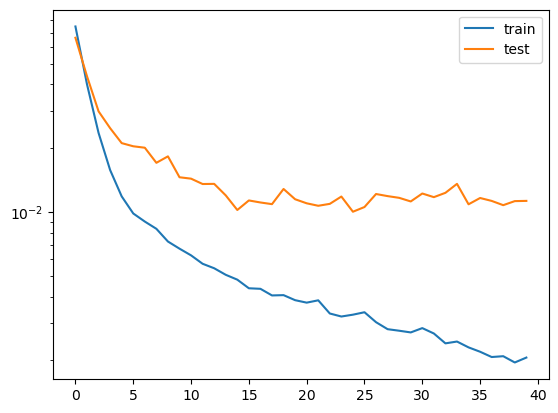

In [57]:
plt.plot(history_res_PCA.history['loss'], label='train')
plt.plot(history_res_PCA.history['val_loss'], label='test')
plt.yscale('log')
plt.legend()
plt.show()

loss_res = history_res_PCA.history['loss'][-1]

1/1 [==============================] - 0s 16ms/step
tf.Tensor(-0.1837671, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

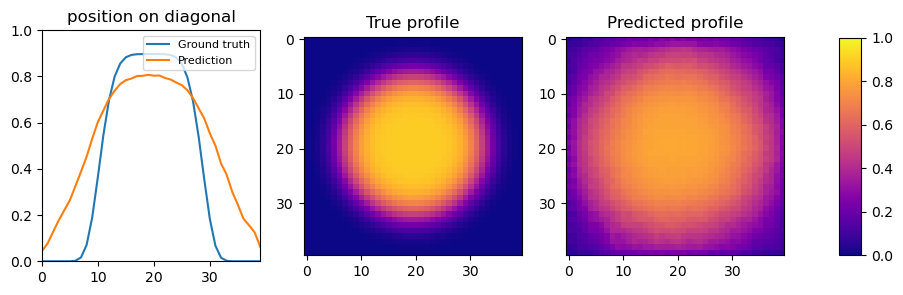

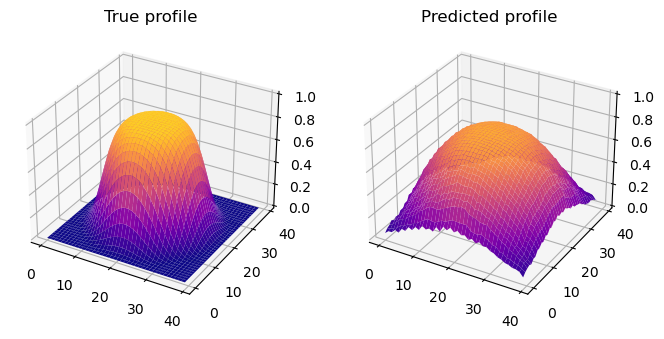

In [53]:
ResCompareProfiles(saved_resolved_PCA, x=x_pca_test, y=y_test_new)